# PINNs-Based 1D Acoustic Wave Simulation with a Source Term

This notebook presents the numerical solution for the 1D elastic wave equation

The acoustic wave equation in 1D with constant density 

$$
\partial^2_t u(x,t) \ = \ c^2 \partial_x^2 u(x,t) + s(x,t)
$$

with pressure $p$, acoustic velocity $c$, and source term $s$.

In the following code block, we import the necessary libraries for our notebook. This includes NumPy for numerical operations, PyTorch for building and training the neural network, Matplotlib for plotting, a utility module for additional plotting functions, and the time module for timing our training process.

In [9]:
# Import NumPy for numerical operations
import numpy as np

# Import PyTorch for building and training neural networks
import torch
import torch.nn as nn
import torch.optim as optim

# Import Matplotlib for plotting
import matplotlib.pyplot as plt

# Import a utility module for additional plotting functions
import utils_plots

# Import the time module to time our training process
import time

# Import pickle for save and load the variables
import pickle

import random

from scipy.interpolate import griddata

# Ignore Warning Messages
import warnings
warnings.filterwarnings("ignore")

In the following code block, we load the data obteined from a spectral elements implemented in the notebook W9_se_homo_1d_solution.ipynb with modified input parameters of the course [computers, waves, simulations](https://www.coursera.org/learn/computers-waves-simulations).

In [10]:
# Load the variables
with open('5_se_data.pkl', 'rb') as f:
    t_grid, x_grid, u_grid = pickle.load(f)
    
x_grid=np.array(x_grid)
t_grid=np.array(t_grid)
u_grid=np.array(u_grid)    


In [11]:
# Create a grid of 200x200 points
x_new = np.linspace(np.nanmin(x_grid), np.nanmax(x_grid), 300)
t_new = np.linspace(np.nanmin(t_grid), np.nanmax(t_grid), 300)
x_grid_new, t_grid_new = np.meshgrid(x_new, t_new)

# Interpolate the u_grid data to the new grid
points = np.vstack((x_grid.flatten(), t_grid.flatten())).T
values = u_grid.flatten()
u_grid_new = griddata(points, values, (x_grid_new, t_grid_new), method='nearest')


# Replace nan values with the nearest non-nan values
mask = np.isnan(u_grid_new)
u_grid_new[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), u_grid_new[~mask])

In [12]:
x_grid=x_grid_new
t_grid=t_grid_new
u_grid=u_grid_new  

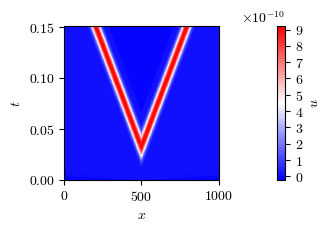

In [13]:
# Create a figure for the plot
# Set the figure size in inches
fig = plt.figure(figsize=(3.2, 2.2))

# Plot the u values as a function of t and x using a filled contour plot
# The 'levels' parameter determines the number and positions of the contour lines / regions
plt.contourf(x_grid_new, t_grid_new, u_grid_new, levels=50,cmap=utils_plots.cmap_)

# Add a colorbar to the plot with the label 'u'
# The colorbar provides a visual guide to the range of values in the plot
plt.colorbar(label='$u$')

# Label the x and y axes
plt.xlabel('$x$')  # Label for the x-axis
plt.ylabel('$t$')  # Label for the y-axis

# Display the plot
plt.show()

In [14]:
# Convert to PyTorch tensors
x_grid_tensor = torch.from_numpy(x_grid).float().unsqueeze(-1)
t_grid_tensor = torch.from_numpy(t_grid).float().unsqueeze(-1)
u_grid_tensor = torch.from_numpy(u_grid).float().unsqueeze(-1)

# Normalize the tensors
x_grid_tensor_normalized = (x_grid_tensor - x_grid_tensor.min()) / (x_grid_tensor.max() - x_grid_tensor.min())
t_grid_tensor_normalized = (t_grid_tensor - t_grid_tensor.min()) / (t_grid_tensor.max() - t_grid_tensor.min())
u_grid_tensor_normalized = (u_grid_tensor - u_grid_tensor.min()) / (u_grid_tensor.max() - u_grid_tensor.min())

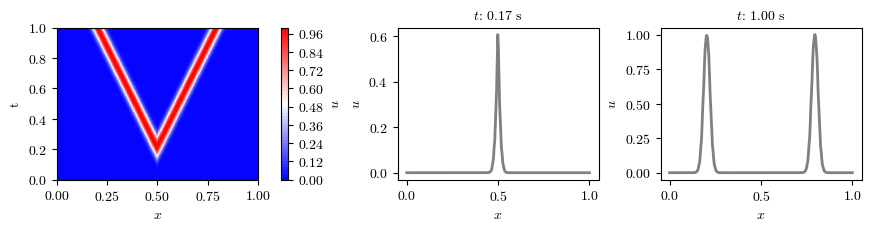

In [16]:
# Convert the tensor back to a numpy array for visualization
u_grid_normalized = u_grid_tensor_normalized.detach().numpy().reshape(x_grid.shape)
x_grid_normalized = x_grid_tensor_normalized.detach().numpy().reshape(x_grid.shape)
t_grid_normalized = t_grid_tensor_normalized.detach().numpy().reshape(x_grid.shape)

fig, axs = plt.subplots(1, 3, figsize=(8.6, 2.2))

# First subplot
contourf_plot=axs[0].contourf(x_grid_normalized, t_grid_normalized, u_grid_normalized, origin='lower', extent=(0, 1, 0, 1), levels=50,cmap=utils_plots.cmap_)
#axs[0].contour(x_grid_tensor_normalized, t_grid_tensor_normalized, u_grid_normalized, levels=50, colors='white', alpha=0.2, linestyles='solid')
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('t')
fig.colorbar(contourf_plot, ax=axs[0], label='$u$')

# Second subplot
axs[1].plot(x_grid_normalized[50,:], u_grid_normalized[50,:], color='gray', linewidth=2)
axs[1].set_xlabel('$x$')
axs[1].set_ylabel('$u$')
axs[1].set_title("$t$: {:.2f} s".format(t_grid_normalized[50,0]),fontsize=10)

# Third subplot
axs[2].plot(x_grid_normalized[299,:], u_grid_normalized[299,:], color='gray', linewidth=2)
axs[2].set_xlabel('$x$')
axs[2].set_ylabel('$u$')
axs[2].set_title("$t$: {:.2f} s".format(t_grid_normalized[299,0]),fontsize=10)

plt.show()

In [17]:
# Concatenation of x and y to form the input data
input_data = torch.cat((x_grid_tensor_normalized, t_grid_tensor_normalized), dim=-1)
output_data = u_grid_tensor_normalized

In [18]:
# Define a neural network class with three fully connected layers
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(2, 20)
        self.layer2 = nn.Linear(20, 20)
        self.layer3 = nn.Linear(20, 20)
        self.output_layer = nn.Linear(20, 1)

    def forward(self, x):
        x = torch.tanh(self.layer1(x))
        x = torch.tanh(self.layer2(x))
        x = torch.tanh(self.layer3(x))
        x = self.output_layer(x)
        return x
    
# Create an instance of the neural network
neural_net = NeuralNetwork()

# Define an optimizer (Adam) for training the network
optimizer = optim.Adam(neural_net.parameters(), lr=0.01)

# Define a loss function (Mean Squared Error) for training the network
loss_func = nn.MSELoss()

In [23]:
#Concatenation of x and y to form the input data
input_data = torch.cat((x_grid_tensor_normalized, t_grid_tensor_normalized), dim=-1)

# Select 300 random indices from the first dimension of input_data
#indices_1 = random.sample(range(input_data.shape[0]), 300)

# Select 300 random indices from the second dimension of input_data
#indices_2 = random.sample(range(input_data.shape[1]), 300)

# Use only the selected indices for training
selected_data = input_data[:, :100][:, :100]

# Select the same indices from u_grid_tensor_normalized
u_grid_tensor_normalized_sd = u_grid_tensor_normalized[:, :100][:, :100]

print(selected_data.shape)

torch.Size([300, 100, 2])


In [24]:
# Initialize a list to store the loss values
loss_values = []

# Start the timer
start_time = time.time()

# Training the neural network
for i in range(10_001):
    prediction = neural_net(selected_data)     # input x and predict based on x
    loss = loss_func(prediction, u_grid_tensor_normalized_sd)     # must be (1. nn output, 2. target)
    
    # Append the current loss value to the list
    loss_values.append(loss.item())
    
    if i % 1000 == 0:  # print every 100 iterations
        print(f"Iteration {i}: Loss {loss.item()}")
    
    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()

# Stop the timer and calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time} seconds")

# Save a summary of the training process to a text file
with open("summaries/2_1D_Wave_Equation_Approximation_with_NNs.txt", "w") as file:
    file.write("Summary of Neural Network Training\n")
    file.write("=================================\n\n")
    file.write(f"Neural Network Architecture:\n{neural_net}\n\n")
    file.write(f"Optimizer Used:\n{type(optimizer).__name__}\n\n")
    file.write(f"Learning Rate:\n{optimizer.param_groups[0]['lr']}\n\n")
    file.write(f"Number of Iterations:\n{len(loss_values)}\n\n")
    file.write(f"Initial Loss:\n{loss_values[0]}\n\n")
    file.write(f"Final Loss:\n{loss_values[-1]}\n\n")
    file.write(f"Training Time:\n{elapsed_time} seconds\n\n")
    
    # Calculate the average loss
    average_loss = sum(loss_values) / len(loss_values)
    file.write(f"Average Loss:\n{average_loss}\n\n")
    
    # Find the iteration with the minimum loss
    min_loss_value = min(loss_values)
    min_loss_iteration = loss_values.index(min_loss_value)
    file.write(f"Minimum Loss:\n{min_loss_value} at iteration {min_loss_iteration}\n\n")        

Iteration 0: Loss 0.04876250401139259
Iteration 1000: Loss 0.0030772779136896133
Iteration 2000: Loss 2.424864942440763e-05
Iteration 3000: Loss 1.6840385796967894e-05
Iteration 4000: Loss 1.6292426153086126e-05
Iteration 5000: Loss 1.6000820323824883e-05
Iteration 6000: Loss 1.581999458721839e-05
Iteration 7000: Loss 1.5657000403734855e-05
Iteration 8000: Loss 1.609786704648286e-05
Iteration 9000: Loss 1.5275063560693525e-05
Iteration 10000: Loss 1.5129675375646912e-05
Training time: 109.46312260627747 seconds


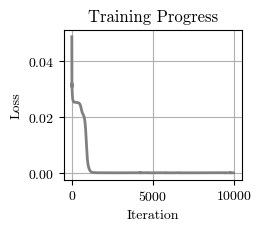

In [25]:
# Create a figure for the plot
fig = plt.figure(figsize=(2.5, 2.2))

# Plot the loss values recorded during training
plt.plot(loss_values, color='gray', linewidth=2)

# Set the labels for the x and y axes
plt.xlabel('Iteration')
plt.ylabel('Loss')

# Set the title for the plot
plt.title('Training Progress')

# Display the grid
plt.grid(True)

# Save the plot as a PDF file in the 'imgs' directory
fig.savefig('imgs/4_Training_Progress.png', format='png')

# Display the plot
plt.show()

In [26]:
# Save the trained model's parameters to a file
torch.save(neural_net.state_dict(), 'models/4_1D_Wave_Equation_NNs.pth')

# Initialize a new instance of the neural network
new_neural_net = NeuralNetwork()

# Load the saved parameters into the new instance of the neural network
new_neural_net.load_state_dict(torch.load('models/4_1D_Wave_Equation_NNs.pth'))

# Ensure the new neural network is in evaluation mode
new_neural_net.eval()

NeuralNetwork(
  (layer1): Linear(in_features=2, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=20, bias=True)
  (layer3): Linear(in_features=20, out_features=20, bias=True)
  (output_layer): Linear(in_features=20, out_features=1, bias=True)
)

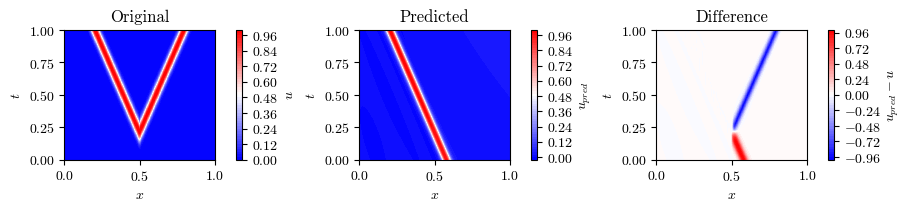

In [27]:
# Generate predictions using the neural network and reshape to match grid
# Concatenation of x and y to form the input data
input_data = torch.cat((x_grid_tensor_normalized, t_grid_tensor_normalized), dim=-1)
u_pred = neural_net(input_data).detach().numpy().reshape(x_grid_normalized.shape)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 3, figsize=(9, 2))

# Define a function to plot a contour graph
def plot_contour(ax, x, y, z, title, label):
    im = ax.contourf(x, y, z, origin='lower', levels=50, cmap=utils_plots.cmap_)
    ax.set_title(title)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')
    fig.colorbar(im, ax=ax, label=label)
    #ax.contour(x, y, z, levels=20, colors='white', alpha=0.2, linestyles='solid')

# Plot the predicted u values
plot_contour(axs[0], x_grid_normalized, t_grid_normalized, u_grid_normalized, 'Original', '$u$')

# Plot the predicted u values
plot_contour(axs[1], x_grid_normalized, t_grid_normalized, u_pred, 'Predicted', '$u_{pred}$')

# Plot the difference between the predicted and analytical u values
plot_contour(axs[2], x_grid_normalized, t_grid_normalized, u_pred-u_grid_normalized, 'Difference', '$u_{pred}-u$')

# Save the plot as a PDF file in the 'imgs' directory

#fig.savefig('imgs/2_Predicted_and_Difference_3_1D_Wave_Equation_Approximation_with_NNs.png', format='png')

# Display the plot
plt.show()

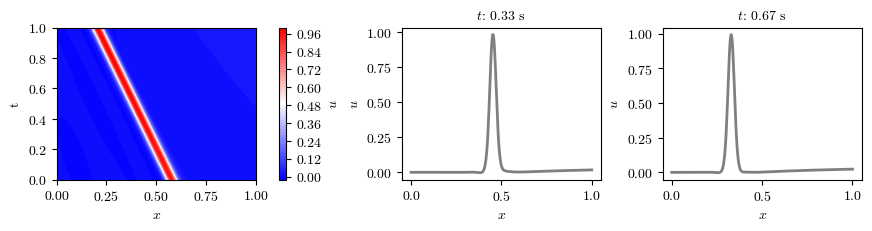

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(8.6, 2.2))

# First subplot
contourf_plot=axs[0].contourf(x_grid_normalized, t_grid_normalized, u_pred, origin='lower', extent=(0, 1, 0, 1), levels=50,cmap=utils_plots.cmap_)
#axs[0].contour(x_grid_tensor_normalized, t_grid_tensor_normalized, u_grid_normalized, levels=50, colors='white', alpha=0.2, linestyles='solid')
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('t')
fig.colorbar(contourf_plot, ax=axs[0], label='$u$')

# Second subplot
axs[1].plot(x_grid_normalized[100,:], u_pred[100,:], color='gray', linewidth=2)
axs[1].set_xlabel('$x$')
axs[1].set_ylabel('$u$')
axs[1].set_title("$t$: {:.2f} s".format(t_grid_normalized[100,0]),fontsize=10)

# Third subplot
axs[2].plot(x_grid_normalized[199,:], u_pred[199,:], color='gray', linewidth=2)
axs[2].set_xlabel('$x$')
axs[2].set_ylabel('$u$')
axs[2].set_title("$t$: {:.2f} s".format(t_grid_normalized[199,0]),fontsize=10)

plt.show()